In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import lightgbm as lgb
from tqdm.auto import tqdm

In [2]:
DATA_ROOT   = Path('./data')
WORKING_DIR = Path('./')
STUDY_PATH = WORKING_DIR / 'studies'

In [3]:
n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=False)

X = pd.read_parquet(DATA_ROOT / 'working_dataset.parquet')
y = pd.read_csv(DATA_ROOT / 'train_labels.csv')['imdb_score']

In [4]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        try:
            y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        except AttributeError:
            y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

In [5]:
def train(params):
    fitted_models = []
    cv_scores = []
    maes = []


    for idx_train, idx_valid in tqdm(cv.split(X, y), total=n_splits):
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            #callbacks=[lgb.log_evaluation(200), lgb.early_stopping(60)]
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )
        fitted_models.append(model)
    
        y_pred = model.predict(X_valid)

        mse_score = mean_squared_error(y_valid, y_pred)
        mae_score = np.abs(y_valid - y_pred)
        
        cv_scores.append(mse_score)
        maes.append(mae_score)
    
    model = VotingModel(fitted_models)

    return model, cv_scores, np.concatenate(maes)

In [6]:
import joblib

# Create or load the study
def create_or_load_study(study_name, storage=None):
    try:
        study = joblib.load(f"{STUDY_PATH}/{study_name}.pkl")
        print(f"Loaded study '{study_name}' from file.")
    except FileNotFoundError:
        study = optuna.create_study(study_name=study_name, storage=storage, direction='minimize')
        print(f"Created new study '{study_name}'.")
    return study

# Function to save the study
def save_study(study, study_name):
    joblib.dump(study, f"{STUDY_PATH}/{study_name}.pkl")
    print(f"Study '{study_name}' saved to file.")

In [7]:
import optuna

def objective(trial):
    params = {
            'metric': 'rmse', 
            'random_state': 48,
            'n_estimators': 20000,
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
            'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
            'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
            'verbose': -1
        }

    model, cv_scores = train(params)

    #print(f'======= Mean of scores: {np.mean(cv_scores):.3f}±{2*np.std(cv_scores):.3f} =======')
    return np.mean(cv_scores)


study_name = 'optuna'
study = create_or_load_study(study_name)

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    #print(f"Best value: {study.best_value}, Best params: {trial.best_trial.params}")

    study_df = study.trials_dataframe()
    save_study(study, study_name)
    study_df.to_csv('optuna.csv', index=False)


# study.optimize(objective, n_trials=40, callbacks=[print_callback], n_jobs=1, show_progress_bar=True)

Loaded study 'optuna' from file.


In [8]:
params = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha':  study.best_trial.params['reg_alpha'],
        'reg_lambda':  study.best_trial.params['reg_lambda'],
        'colsample_bytree':  study.best_trial.params['colsample_bytree'],
        'subsample':  study.best_trial.params['subsample'],
        'learning_rate':  study.best_trial.params['learning_rate'],
        'max_depth':  study.best_trial.params['max_depth'],
        'num_leaves' :  study.best_trial.params['num_leaves'],
        'min_child_samples':  study.best_trial.params['min_child_samples'],
        'cat_smooth' :  study.best_trial.params['min_data_per_groups'],
        'verbose': -1

    }
    
model, cv_scores, mae_score = train(params)

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
f'{np.mean(mae_score): .4f} ± {2*np.std(mae_score): .4f}'

' 0.2421 ±  0.5461'

In [10]:
f'{np.mean(cv_scores): .4f} ± {2*np.std(cv_scores): .4f}' # before 0.1332 ±  0.0260

' 0.1332 ±  0.0260'

In [17]:
import joblib
joblib.dump(model, WORKING_DIR / 'models/regression.pkl')

['models/regression.pkl']

## Feature Importance

In [11]:
import shap

shap_acc = None
X_acc = None

for i, (idx_train, idx_valid) in tqdm(enumerate(cv.split(X, y)), total=n_splits):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
    
    explainer = shap.TreeExplainer(model.estimators[i])
    shap_values = explainer.shap_values(X_train)
    
    if shap_acc is not None:
        shap_acc = np.concatenate([shap_acc, shap_values])
    else:
        shap_acc = shap_values
    
    if X_acc is not None:
        X_acc = pd.concat([X_acc, X_train])
    else:
        X_acc = X_train

  0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
X.shape

(2894, 42)

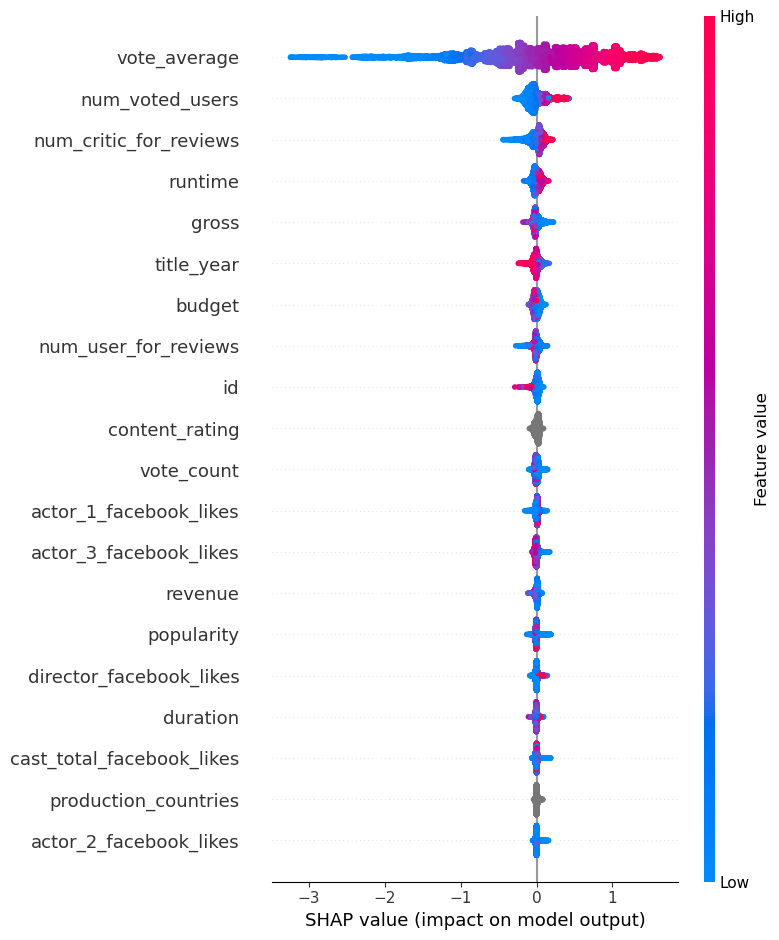

In [13]:
shap.summary_plot(shap_acc, X_acc)